In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    average_precision_score, precision_recall_curve, auc
)
from xgboost import XGBClassifier
import optuna

np.random.seed(1337)

# Load dataset
df = pd.read_csv('../data/output/netflix-cleaned.csv')

# Check basic info
print(df.info())

# Check for missing values
print(df.isnull().sum())

# Summary statistics
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   customer_id        5000 non-null   object
 1   age                5000 non-null   int64 
 2   gender             5000 non-null   object
 3   subscription_type  5000 non-null   object
 4   watch_hours        5000 non-null   int64 
 5   last_login_days    5000 non-null   int64 
 6   region             5000 non-null   object
 7   primary_device     5000 non-null   object
 8   churned            5000 non-null   int64 
 9   payment_method     5000 non-null   object
 10  profile_count      5000 non-null   int64 
 11  favorite_genre     5000 non-null   object
 12  tenure_days        5000 non-null   int64 
 13  multi_device       5000 non-null   int64 
 14  activity_level     5000 non-null   object
 15  genres_watched     5000 non-null   int64 
 16  support_tickets    5000 non-null   int64 


In [2]:
df.head()

,customer_id,age,gender,subscription_type,watch_hours,last_login_days,region,primary_device,churned,payment_method,profile_count,favorite_genre,tenure_days,multi_device,activity_level,genres_watched,support_tickets
0,a9b75100-82a8-427a-a208-72f24052884a,51,Male,Standard with ads,226,88,Africa,Tablet,0,Credit Card,1,Action,257,1,Idle,3,2
1,49a5dfd9-7e69-4022-a6ad-0a1b9767fb5b,47,Male,Premium,491,22,Europe,TV,0,Credit Card,5,Sci-Fi,307,0,Active,2,0
2,4d71f6ce-fca9-4ff7-8afa-197ac24de14b,27,Female,Standard with ads,219,24,North America,TV,0,Credit Card,2,Drama,101,0,Active,2,1
3,d3c72c38-631b-4f9e-8a0e-de103cad1a7d,53,Male,Premium,43,15,North America,TV,0,Credit Card,2,Horror,49,1,Active,2,0
4,4e265c34-103a-4dbb-9553-76c9aa47e946,56,Male,Premium,588,12,North America,Mobile,0,Digital Wallet,2,Action,610,1,Active,5,1


In [3]:
# Feature Engineering

# avg watch hours per day
df["avg_watch_hours_per_day"] = df["watch_hours"] / df["tenure_days"].replace(0, 1)

# age buckets
# bins = [17, 24, 34, 44, 54, 64, 70]
# labels = ["18-24", "25-34", "35-44", "45-54", "55-64", "65-70"]
# df["age_bucket"] = pd.cut(df["age"], bins=bins, labels=labels)

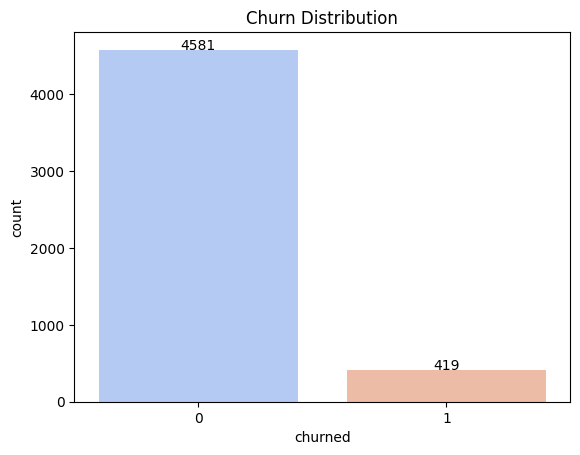

In [4]:
# Churn distribution
ax = sns.countplot(x=df['churned'], palette="coolwarm", hue=df['churned'], legend=False)
plt.title("Churn Distribution")

# Add value labels on top of each bar
for p in ax.patches:
    height = p.get_height()
    ax.text(
        x=p.get_x() + p.get_width() / 2,  # x-coordinate: center of bar
        y=height + 0.5,                   # y-coordinate: slightly above the bar
        s=int(height),                    # label: height of the bar
        ha='center'                       # horizontal alignment
    )

plt.show()

In [5]:
# -------------------------
# One-hot encode categorical variables
# -------------------------
features = [
    # 'age',
    # 'gender',
    'subscription_type', ##
    'watch_hours', #
    'last_login_days', #
    'region',
    'primary_device',
    'payment_method', ##
    # 'profile_count',
    # 'favorite_genre',
    'tenure_days', #
    'multi_device',
    'activity_level',#           # categorical
    'genres_watched',
    'support_tickets', #
    "avg_watch_hours_per_day",#  # derived
]

categorical_cols = [f for f in features if df[f].dtype == "object"]
df_encoded = pd.get_dummies(df[features + ["churned"]], columns=categorical_cols, drop_first=True)

# -------------------------
# Train-test split
# -------------------------
X = df_encoded.drop(columns=['churned'])
y = df_encoded['churned']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1337, stratify=y
)

# -------------------------
# Scale numeric features (Logistic Regression needs scaling)
# -------------------------
num_features = [f for f in features if df[f].dtype in ['int64', 'float64']]

scaler = StandardScaler()
X_train[num_features] = scaler.fit_transform(X_train[num_features])
X_test[num_features] = scaler.transform(X_test[num_features])

# -------------------------
# Helper function: Model Evaluation
# -------------------------
def evaluate_model(y_true, y_pred, y_prob, model_name="Model"):
    print(f"\n=== {model_name} ===")
    print(classification_report(y_true, y_pred, digits=3))
    print(f"ROC-AUC: {roc_auc_score(y_true, y_prob):.3f}")
    print(f"PR-AUC: {average_precision_score(y_true, y_prob):.3f}")
    
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=['Not Churned', 'Churned'],
                yticklabels=['Not Churned', 'Churned'])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"{model_name} Confusion Matrix")
    plt.show()



=== Logistic Regression ===
              precision    recall  f1-score   support

           0      0.947     0.699     0.804       916
           1      0.148     0.571     0.235        84

    accuracy                          0.688      1000
   macro avg      0.547     0.635     0.520      1000
weighted avg      0.880     0.688     0.756      1000

ROC-AUC: 0.691
PR-AUC: 0.249


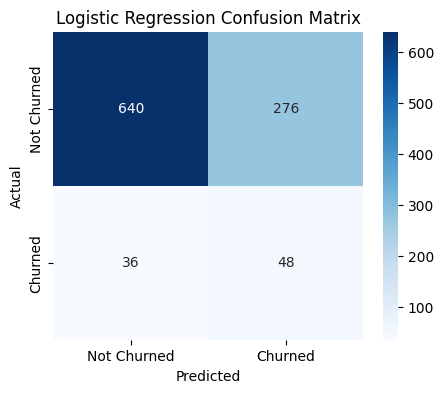

In [6]:
# -------------------------
# Logistic Regression (baseline)
# -------------------------
log_reg = LogisticRegression(class_weight="balanced", max_iter=1000, random_state=1337)
log_reg.fit(X_train, y_train)
y_pred_lr = log_reg.predict(X_test)
y_prob_lr = log_reg.predict_proba(X_test)[:, 1]
prec_lr, rec_lr, _ = precision_recall_curve(y_test, y_prob_lr)
evaluate_model(y_test, y_pred_lr, y_prob_lr, "Logistic Regression")

In [7]:
def rf_objective(trial, X_train, y_train):
    """
    Objective function for Optuna to optimize a RandomForestClassifier.
    """
    # Define the hyperparameters to search
    rf_params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500, step=50),
        'max_depth': trial.suggest_int('max_depth', 5, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),
        'class_weight': 'balanced',
        'random_state': 1337
    }

    # Cross-validation setup
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1337)
    cv_pr_aucs = []

    for train_idx, val_idx in skf.split(X_train, y_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model = RandomForestClassifier(**rf_params)
        model.fit(X_tr, y_tr)
        
        y_prob = model.predict_proba(X_val)[:, 1]
        prec, rec, _ = precision_recall_curve(y_val, y_prob)
        cv_pr_aucs.append(auc(rec, prec))
    
    # Return the average PR-AUC across all folds
    return np.mean(cv_pr_aucs)

# Run the optimization
study_rf = optuna.create_study(direction='maximize')
study_rf.optimize(lambda trial: rf_objective(trial, X_train, y_train), n_trials=50)

print(f"Best RF PR-AUC: {study_rf.best_value:.3f}")
print("Best RF Hyperparameters:")
print(study_rf.best_params)

[I 2025-09-17 11:54:10,099] A new study created in memory with name: no-name-d30e7ca3-4f32-4256-8990-edaf7368e2d6
[I 2025-09-17 11:54:14,186] Trial 0 finished with value: 0.3137511428576632 and parameters: {'n_estimators': 450, 'max_depth': 18, 'min_samples_leaf': 3, 'min_samples_split': 2, 'criterion': 'gini'}. Best is trial 0 with value: 0.3137511428576632.
[I 2025-09-17 11:54:16,246] Trial 1 finished with value: 0.3112952179153706 and parameters: {'n_estimators': 350, 'max_depth': 5, 'min_samples_leaf': 6, 'min_samples_split': 9, 'criterion': 'gini'}. Best is trial 0 with value: 0.3137511428576632.
[I 2025-09-17 11:54:18,316] Trial 2 finished with value: 0.3119220303809464 and parameters: {'n_estimators': 250, 'max_depth': 8, 'min_samples_leaf': 10, 'min_samples_split': 6, 'criterion': 'entropy'}. Best is trial 0 with value: 0.3137511428576632.
[I 2025-09-17 11:54:22,371] Trial 3 finished with value: 0.3133294321604743 and parameters: {'n_estimators': 450, 'max_depth': 13, 'min_samp

Best RF PR-AUC: 0.324
Best RF Hyperparameters:
{'n_estimators': 250, 'max_depth': 9, 'min_samples_leaf': 8, 'min_samples_split': 4, 'criterion': 'entropy'}



=== Random Forest ===
              precision    recall  f1-score   support

           0      0.952     0.945     0.949       916
           1      0.444     0.476     0.460        84

    accuracy                          0.906      1000
   macro avg      0.698     0.711     0.704      1000
weighted avg      0.909     0.906     0.907      1000

ROC-AUC: 0.750
PR-AUC: 0.349


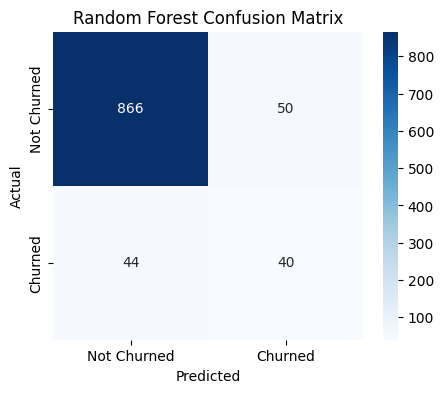

In [8]:
# -------------------------
# Random Forest (balanced class weight)
# -------------------------
# default settings
rf_default_model = RandomForestClassifier(n_estimators=200, class_weight="balanced", random_state=1337)

rf_optuna_params = {'n_estimators': 100, 'max_depth': 9, 'min_samples_leaf': 1, 'min_samples_split': 7, 'criterion': 'entropy'}
rf_model = RandomForestClassifier(
    **rf_optuna_params,
    class_weight="balanced",
    random_state=1337
)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
y_prob_rf = rf_model.predict_proba(X_test)[:, 1]
prec_rf, rec_rf, _ = precision_recall_curve(y_test, y_prob_rf)
evaluate_model(y_test, y_pred_rf, y_prob_rf, "Random Forest")

In [9]:
neg, pos = np.bincount(y_train)
scale_pos_weight = neg / pos

def xgb_objective(trial, X_train, y_train, scale_pos_weight):
    """
    Objective function for Optuna to optimize an XGBoostClassifier.
    """
    # Define the hyperparameters to search
    xgb_params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=100),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0.0, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
        'scale_pos_weight': scale_pos_weight,
        'random_state': 1337,
        'eval_metric': 'logloss'
    }

    # Cross-validation setup
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1337)
    cv_pr_aucs = []

    for train_idx, val_idx in skf.split(X_train, y_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model = XGBClassifier(**xgb_params)
        model.fit(X_tr, y_tr)
        
        y_prob = model.predict_proba(X_val)[:, 1]
        prec, rec, _ = precision_recall_curve(y_val, y_prob)
        cv_pr_aucs.append(auc(rec, prec))
    
    # Return the average PR-AUC across all folds
    return np.mean(cv_pr_aucs)

# Run the optimization
study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(lambda trial: xgb_objective(trial, X_train, y_train, scale_pos_weight), n_trials=50)

print(f"Best XGBoost PR-AUC: {study_xgb.best_value:.3f}")
print("Best XGBoost Hyperparameters:")
print(study_xgb.best_params)

[I 2025-09-17 11:55:43,156] A new study created in memory with name: no-name-964760e8-1097-4dc8-b966-6f1798f292a7
[I 2025-09-17 11:55:44,143] Trial 0 finished with value: 0.30406989534100304 and parameters: {'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.02401928830063689, 'subsample': 0.7852297222416948, 'colsample_bytree': 0.5932643718924544, 'gamma': 0.11103692312382818, 'reg_alpha': 0.822762460759621, 'reg_lambda': 0.6730348125116775}. Best is trial 0 with value: 0.30406989534100304.
[I 2025-09-17 11:55:49,988] Trial 1 finished with value: 0.30094225386531 and parameters: {'n_estimators': 900, 'max_depth': 10, 'learning_rate': 0.010395910356814333, 'subsample': 0.9964046949710587, 'colsample_bytree': 0.9571729349766998, 'gamma': 0.4862716256323164, 'reg_alpha': 0.004817499446124862, 'reg_lambda': 0.21745060003380212}. Best is trial 0 with value: 0.30406989534100304.
[I 2025-09-17 11:55:52,165] Trial 2 finished with value: 0.2959537441374701 and parameters: {'n_estimators':

Best XGBoost PR-AUC: 0.328
Best XGBoost Hyperparameters:
{'n_estimators': 100, 'max_depth': 8, 'learning_rate': 0.061590219186094454, 'subsample': 0.5142150842307477, 'colsample_bytree': 0.7802130443577104, 'gamma': 0.6389729871832472, 'reg_alpha': 0.7675194081779668, 'reg_lambda': 0.8002858916252336}


scale_pos_weight: 10.94
XGBoost CV ROC-AUC: 0.724
XGBoost CV PR-AUC: 0.320
Best threshold for F1: 0.65
F1 at best threshold: 0.488, Recall: 0.476

=== XGBoost ===
              precision    recall  f1-score   support

           0      0.952     0.956     0.954       916
           1      0.500     0.476     0.488        84

    accuracy                          0.916      1000
   macro avg      0.726     0.716     0.721      1000
weighted avg      0.914     0.916     0.915      1000

ROC-AUC: 0.756
PR-AUC: 0.372


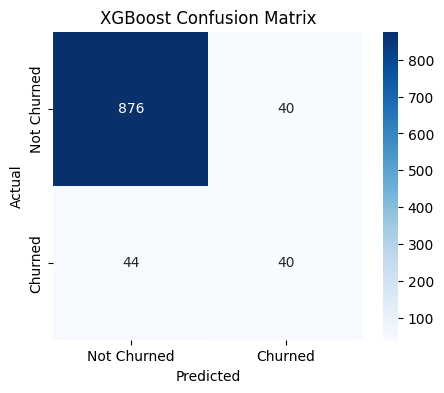

In [10]:
# -------------------------
# XGBoost with CV and Threshold Tuning
# -------------------------
neg, pos = np.bincount(y_train)
scale_pos_weight = neg / pos
print(f"scale_pos_weight: {scale_pos_weight:.2f}")

# default settings
xgb_default_model = XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    random_state=1337,
    eval_metric="logloss"
)

xgb_optuna_params = {
    'n_estimators': 500,
    'max_depth': 6,
    'learning_rate': 0.0171582861937582,
    'subsample': 0.7433692474142617,
    'colsample_bytree': 0.7077427891336296,
    'gamma': 0.26947176204850554,
    'reg_alpha': 0.0749753635490964,
    'reg_lambda': 0.6192216386439605
}

xgb_model = XGBClassifier(
    **xgb_optuna_params,
    scale_pos_weight=scale_pos_weight,
    random_state=1337,
    eval_metric="logloss"
)

# Cross-validation metrics
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1337)
cv_roc, cv_pr = [], []

for train_idx, val_idx in skf.split(X_train, y_train):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
    xgb_model.fit(X_tr, y_tr)
    y_val_pred = xgb_model.predict_proba(X_val)[:, 1]
    cv_roc.append(roc_auc_score(y_val, y_val_pred))
    prec, rec, _ = precision_recall_curve(y_val, y_val_pred)
    cv_pr.append(auc(rec, prec))

print(f"XGBoost CV ROC-AUC: {np.mean(cv_roc):.3f}")
print(f"XGBoost CV PR-AUC: {np.mean(cv_pr):.3f}")

# Train full set
xgb_model.fit(X_train, y_train)
y_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]

# Threshold tuning
precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba_xgb)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-9)
best_idx = np.argmax(f1_scores)
best_thresh = thresholds[best_idx]
print(f"Best threshold for F1: {best_thresh:.2f}")
print(f"F1 at best threshold: {f1_scores[best_idx]:.3f}, Recall: {recalls[best_idx]:.3f}")

y_pred_xgb = (y_proba_xgb >= best_thresh).astype(int)
prec_xgb, rec_xgb, _ = precision_recall_curve(y_test, y_proba_xgb)
evaluate_model(y_test, y_pred_xgb, y_proba_xgb, "XGBoost")

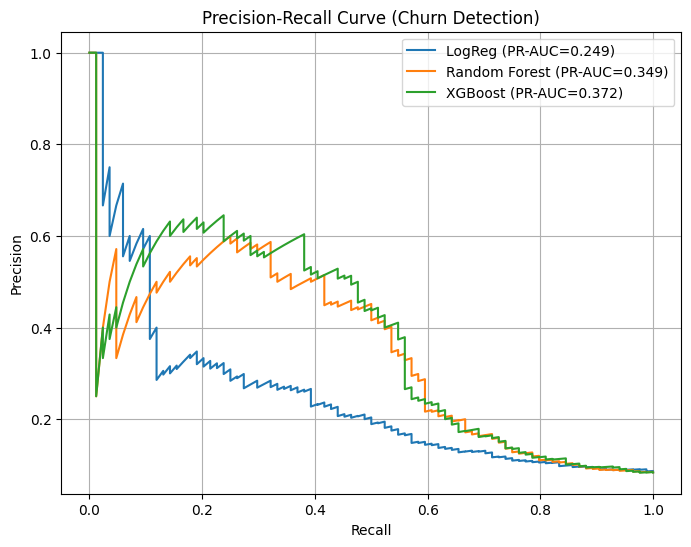

In [11]:
# -------------------------
# PR Curve for All Models
# -------------------------
plt.figure(figsize=(8,6))
plt.plot(rec_lr, prec_lr, label=f"LogReg (PR-AUC={average_precision_score(y_test, y_prob_lr):.3f})")
plt.plot(rec_rf, prec_rf, label=f"Random Forest (PR-AUC={average_precision_score(y_test, y_prob_rf):.3f})")
plt.plot(rec_xgb, prec_xgb, label=f"XGBoost (PR-AUC={average_precision_score(y_test, y_proba_xgb):.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (Churn Detection)")
plt.legend()
plt.grid()
plt.show()

Features used in model:
['watch_hours', 'last_login_days', 'tenure_days', 'multi_device', 'genres_watched', 'support_tickets', 'avg_watch_hours_per_day', 'subscription_type_Standard', 'subscription_type_Standard with ads', 'region_Asia', 'region_Europe', 'region_North America', 'region_Oceania', 'region_South America', 'primary_device_Laptop', 'primary_device_Mobile', 'primary_device_TV', 'primary_device_Tablet', 'payment_method_Debit Card', 'payment_method_Digital Wallet', 'payment_method_Third-party Bundle', 'activity_level_At-risk', 'activity_level_Idle']
Total number of features: 23

Top 10 XGBoost Features by Importance:
support_tickets              0.083960
activity_level_At-risk       0.062556
avg_watch_hours_per_day      0.060728
watch_hours                  0.056766
last_login_days              0.051044
tenure_days                  0.047979
activity_level_Idle          0.045990
genres_watched               0.043997
region_Oceania               0.042392
payment_method_Debit Car

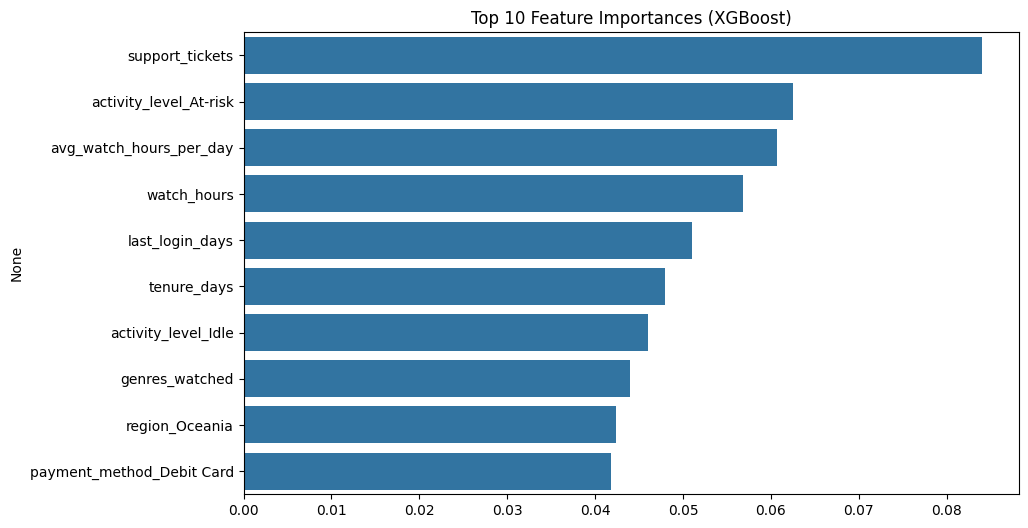

In [15]:
# -------------------------
# Feature Importances (XGBoost)
# -------------------------
# Create a Series of feature importances
importances = pd.Series(xgb_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)

# Feature summary
print("Features used in model:")
print(list(X_train.columns))
print(f"Total number of features: {X_train.shape[1]}")
print("\nTop 10 XGBoost Features by Importance:")
print(importances.head(10))

# Plot top 20 feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x=importances.head(10).values, y=importances.head(10).index)
plt.title("Top 10 Feature Importances (XGBoost)")
plt.show()

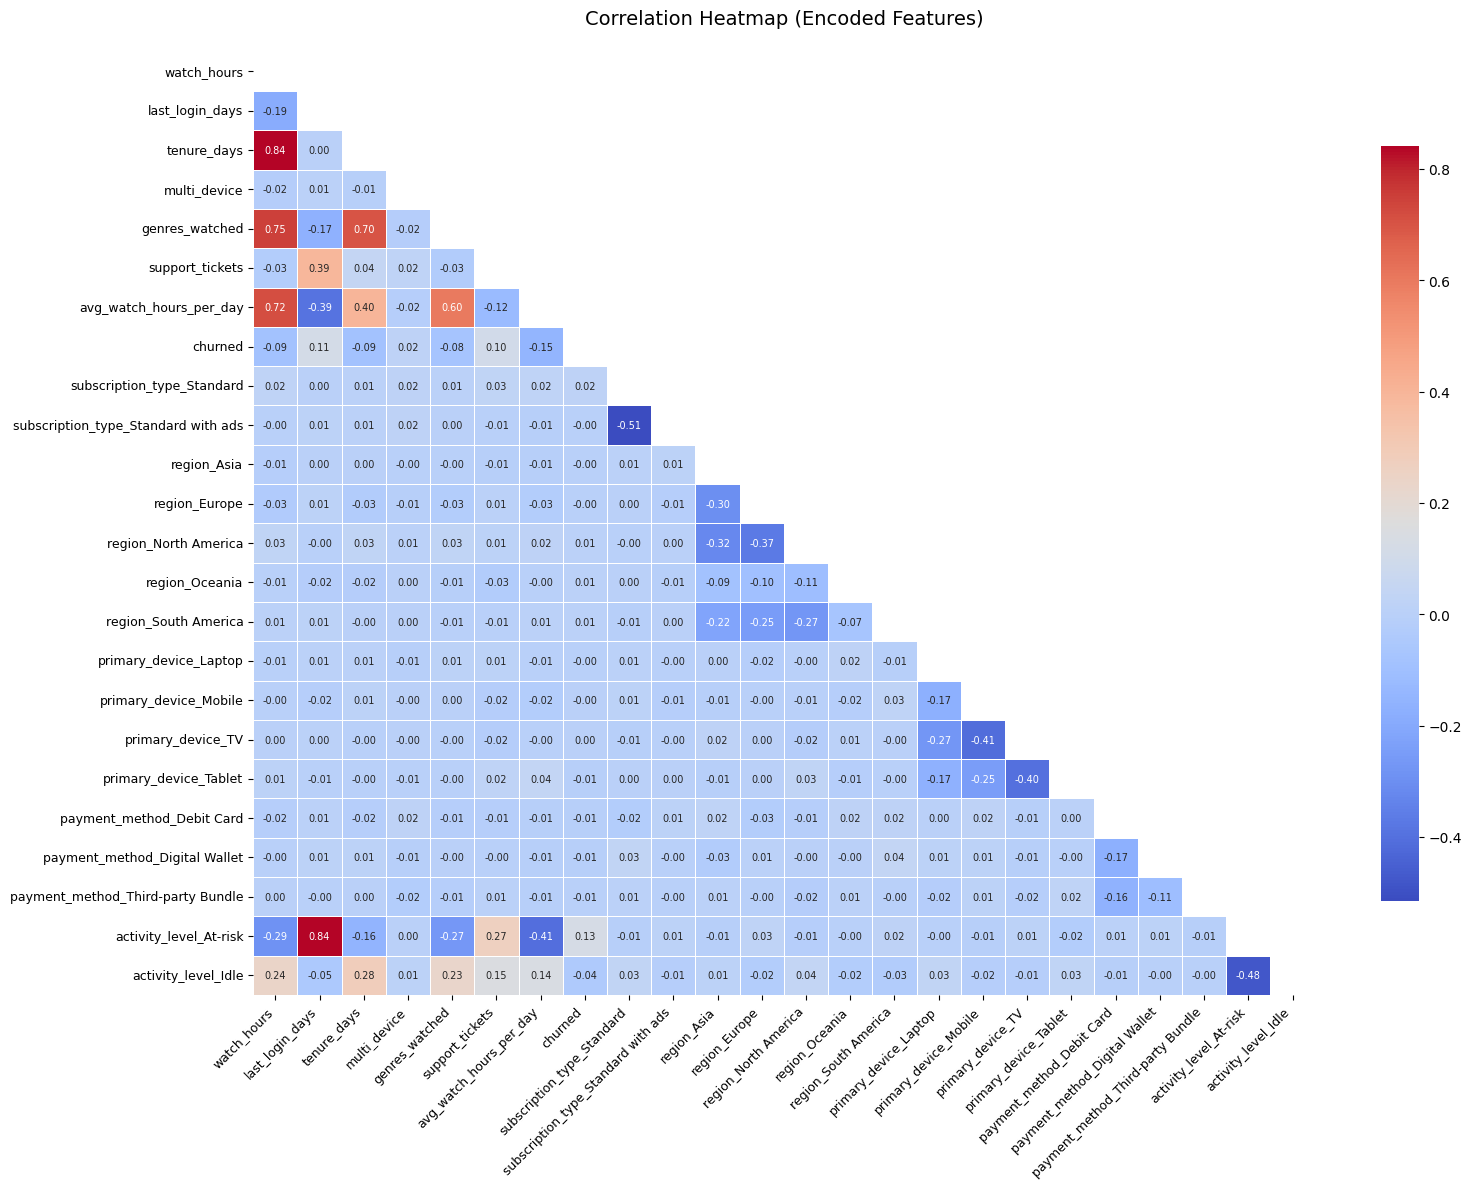

In [16]:
# -------------------------
# Correlation heatmap
# -------------------------
correlation_matrix = df_encoded.corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix, mask=mask, cmap='coolwarm', annot=True,
            fmt='.2f', annot_kws={"size": 7}, linewidths=0.5,
            cbar_kws={"shrink": 0.8})
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.yticks(rotation=0, fontsize=9)
plt.title('Correlation Heatmap (Encoded Features)', fontsize=14, pad=20)
plt.tight_layout()
plt.show()